In [1]:
from IPython.core.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.1)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')
piv_train = train_users.shape[0] # Store length of train_users file
labels = train_users['country_destination'].values

all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True) #Combine train and test for joint processing.
all_users_preserved = all_users

In [3]:
session_df = pd.read_csv('input/sessions.csv')
session_users = session_df

# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

session_df.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,,NaN,Windows Desktop,435
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703
6,d1mm9tcy42,lookup,,NaN,Windows Desktop,115
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842
9,d1mm9tcy42,lookup,,NaN,Windows Desktop,683


In [4]:
## Okay let's try adding all the groupings separately.
session_action = session_users.groupby(['user_id','action']).count()['secs_elapsed'].unstack().fillna(0)
session_action_type = session_users.groupby(['user_id','action_type']).count()['secs_elapsed'].unstack().fillna(0)
session_action_detail = session_actions = session_users.groupby(['user_id','action_detail']).count()['secs_elapsed'].unstack().fillna(0)

sessions_pure = pd.merge(session_action,session_action_type,left_index=True,right_index=True,how='inner')
sessions_pure = sessions_pure.merge(session_action_detail,left_index=True,right_index=True,how='inner')

In [5]:
# Create New Combined Feature for Grouping
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)
print('Number of Action Count Features created:', session_users2.shape[1])
print('\n')

Number of Action Count Features created: 436




In [6]:
# Time spent on each Device
deviceusage_df = session_df[session_df['secs_elapsed']<60*100][['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']
# Number of device types used
deviceusage_df['num_devices'] = session_df.groupby('user_id')['device_type'].agg(lambda x: len(np.unique(x.values)))
deviceusage_df.fillna(0,inplace=True)
deviceusage_df.head(2)

device_type,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,num_devices
user_id,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,25452,0,0,0,0,0,5089,0,2
0010k6l0om,0,0,0,0,0,0,36884,0,0,0,0,0,0,0,1


In [7]:
## Features about individual sessions (sittings)
in_session_actions = session_df[session_df['secs_elapsed']<100*60].groupby('user_id')
AA = in_session_actions['secs_elapsed'].agg({'total_session_times': np.sum,
                                        'mean_secs_per_action' : np.mean,
                                            'num_actions_insession' : np.size})

## Features related to the number of sessions 
between_session_actions = session_df[session_df['secs_elapsed']>200*60].groupby('user_id')
BB = between_session_actions['secs_elapsed'].agg({'num_sessions': np.size,
                                            'mean_between_sessions' : np.mean,
                                            'max_between_sessions': np.max
                                            })

session_times = pd.merge(AA,BB,how='outer',left_index=True,right_index=True)

#Count number of different days spent on AirBnB. Obtained by looking for number of breaks longer than 18 hours.
session_times['num_days'] = session_df[session_df['secs_elapsed']>18*3600].groupby('user_id').count()['secs_elapsed']
session_times.fillna(0,inplace=True)
session_times['num_sessions'] += 1 # Doesn't really make a difference
session_times['num_days'] += 1 
session_times['all_time'] = session_df.groupby('user_id').sum()['secs_elapsed']

session_times.head(3)

,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time
user_id,,,,,,,,
00023iyk9l,30541,32,954.406250,118202.428571,8,567165,3,867896
0010k6l0om,36884,48,768.416667,46397.636364,12,127898,4,586543
001wyh0pz8,96785,78,1240.833333,22506.333333,7,50548,1,282965


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


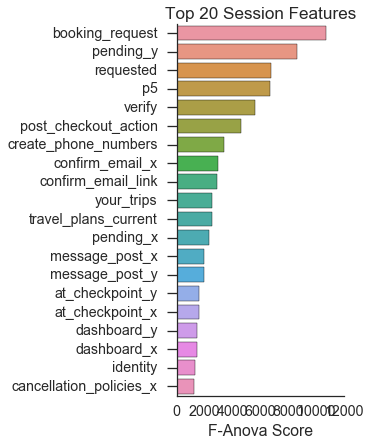

In [16]:
## Need to attach labels for feature selection.
SessionX = pd.merge(train_users[['id','country_destination']],sessions_pure,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']!="NDF" # Turn this into a binary classification problem
SessionX.drop(['id','country_destination'],axis=1,inplace=True)


# Perform selection
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=300)
selector.fit(SessionX,Sessiony)
sessions_pure = sessions_pure[sessions_pure.columns[selector.get_support()]]

# Examine feature selection univariate statistics test results:
FeaturePvalues = pd.Series(index=SessionX.columns,data=selector.pvalues_).sort_values(ascending=True)
FeatureScores = pd.Series(index=SessionX.columns,data=selector.scores_).sort_values(ascending=False)
# Plot
k = 20
plt.figure(figsize=(3,k/3))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
plt.title('Top 20 Session Features')
plt.xlabel('F-Anova Score')
sns.despine()

In [60]:
A = session_df.groupby('user_id').cumsum()
A['user_id'] = session_df['user_id']

b = A['secs_elapsed'].values
A['Diff'] = -(b-(np.append(b[1:],0)))
A['Diff'] = np.insert(A['Diff'].values[:-1],0,0)
A.loc[A['Diff']>100*60,'Diff']=0
A.loc[A['Diff']<1,'Diff']=0


A['Week'] = A['secs_elapsed']//(86400*7)
A['CumDiff'] = A.groupby(['user_id','Week']).cumsum()['Diff']/3600
WeekFeatures = A.groupby(['user_id','Week']).sum()['Diff']
WeekFeatures = WeekFeatures.unstack()[np.arange(0,6)].fillna(0)//3600

In [ ]:
WeekFeatures.head()

In [61]:
## Join all session features together
SessionFeatures = pd.merge(sessions_pure,deviceusage_df,right_index=True,left_index=True,how='inner')
SessionFeatures = pd.merge(SessionFeatures,session_times,right_index=True,left_index=True,how='inner')
SessionFeatures = pd.merge(SessionFeatures,WeekFeatures,right_index=True,left_index=True,how='inner')
print('Total number of Session Features created:', SessionFeatures.shape[1])

Total number of Session Features created: 329


In [ ]:
SessionFeatures.head()

In [ ]:
X = pd.merge(train_users[['id','country_destination']],SessionFeatures,right_index=True,left_on='id',how='inner')
y = X['country_destination']!="NDF" # Turn this into a binary classification problem
X.drop(['id','country_destination'],axis=1,inplace=True)

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = X.loc[:,np.arange(0,6)]

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
RF = RandomForestClassifier(oob_score=True,n_estimators=100,n_jobs=-1)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test,y_pred))


In [ ]:
1 - sum(y)/len(y)

In [ ]:
metrics.accuracy_score(y_pred,y_test)

In [ ]:
sum(y_pred)/len(y_pred)

In [ ]:
FeatureImportances = pd.Series(index=X.columns,data=RF.feature_importances_).sort_values(ascending=False)
k = 100
plt.figure(figsize=(10,20))
sns.barplot(y=FeatureImportances.index[0:k],x=FeatureImportances.head(k))

In [62]:
Sessions = SessionX

In [ ]:
session_df

In [ ]:
session_df.set_index('d')

In [ ]:
A

In [ ]:
A.head()

In [ ]:
a = WeekFeatures.unstack().count(axis=0)
a.cumsum()/a.sum()

In [ ]:
.groupby('user_id').cumsum()

In [63]:
Sessions['Booked']=Sessiony

In [19]:
Sessions

NameError: name 'Sessions' is not defined

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


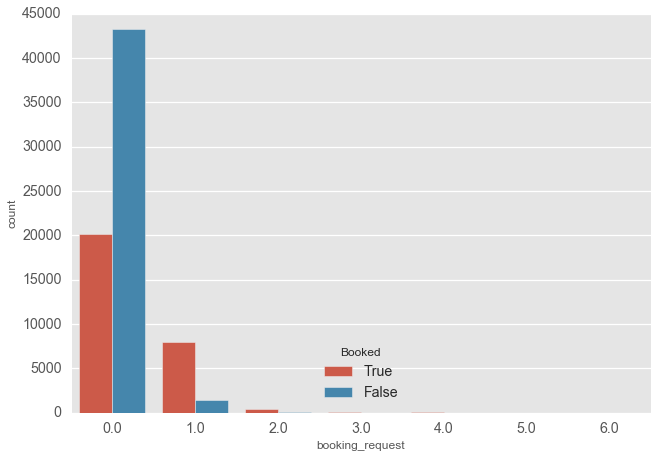

In [64]:
sns.countplot(data=Sessions,hue='Booked',x='booking_request')

In [65]:
# P(Booked|booking request)
sum((Sessions['booking_request']>0)&Sessions['Booked'])/sum(Sessions['booking_request']>0)

0.84634609617114864

In [66]:
# P(Booked|-booking request)
sum((Sessions['booking_request']==0)&Sessions['Booked'])/sum(Sessions['booking_request']==0)

0.31776025236593058

In [68]:
for i in range(0,50):
    I = FeatureScores.index[i]
    temp1 = sum((Sessions[I]>0)&Sessions['Booked'])/sum(Sessions[I]>0)
    print('P(Booked|',I,')=',temp1)
    temp2 = sum((Sessions[I]==0)&Sessions['Booked'])/sum(Sessions[I]==0)
    print('P(Booked|-',I,')=',temp2)
    print('Odds Ratio: ',temp1/temp2)
    print('\n')

P(Booked| booking_request )= 0.846346096171
P(Booked|- booking_request )= 0.317760252366
Odds Ratio:  2.66347376637


P(Booked| pending_y )= 0.87203045019
P(Booked|- pending_y )= 0.333941383923
Odds Ratio:  2.61132789218


P(Booked| requested )= 0.873342736248
P(Booked|- requested )= 0.338093586476
Odds Ratio:  2.5831390218


P(Booked| p5 )= 0.873289120926
P(Booked|- p5 )= 0.338123529767
Odds Ratio:  2.58275169885


P(Booked| verify )= 0.685388127854
P(Booked|- verify )= 0.325340590412
Odds Ratio:  2.10667881


P(Booked| post_checkout_action )= 0.882875081186
P(Booked|- post_checkout_action )= 0.356681786462
Odds Ratio:  2.47524576442


P(Booked| create_phone_numbers )= 0.673881569422
P(Booked|- create_phone_numbers )= 0.323935625703
Odds Ratio:  2.08029471275


P(Booked| confirm_email_x )= 0.503808171432
P(Booked|- confirm_email_x )= 0.306504467548
Odds Ratio:  1.64372211427


P(Booked| confirm_email_link )= 0.503775480442
P(Booked|- confirm_email_link )= 0.307126404362
Odds Ratio:  1

In [ ]:
FeatureScores.index[0]

In [ ]:
FeatureScores

In [28]:
ST = pd.merge(train_users[['id','country_destination']],session_times,right_index=True,left_on='id',how='inner')
ST['Booked'] = ST['country_destination']!='NDF'

In [32]:
ST.head(2)

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked,days_all
137021,d1mm9tcy42,other,57885,86,673.081395,99832.363636,34,606881,21,3427529,True,40
137022,yo8nz8bqcq,NDF,10110,5,2022.000000,49433.000000,5,115983,2,207842,False,2


In [33]:
sns.set_style("whitegrid")


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


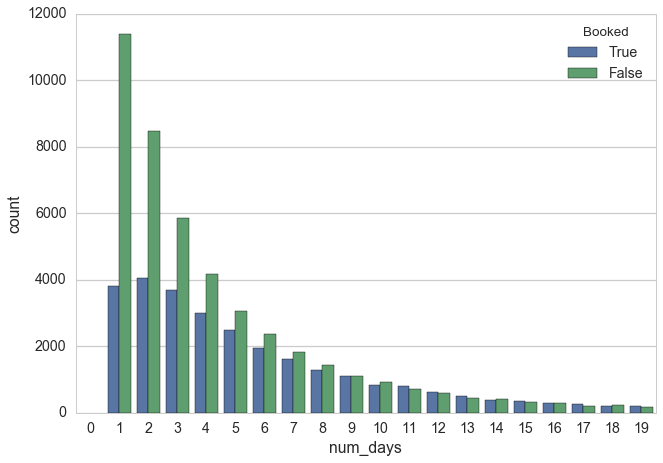

In [34]:
sns.countplot(hue="Booked",x="num_days",data=ST,order=range(0,20))
#plt.ylim([0,20])

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


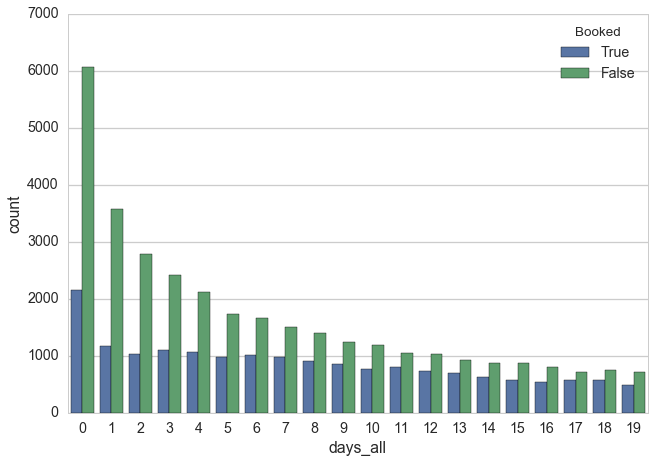

In [35]:
sns.countplot(hue="Booked",x="days_all",data=ST,order=range(0,20))
#plt.ylim([0,20])

In [36]:
np.round(session_times['total_session_times']/(3600))

user_id
00023iyk9l      8
0010k6l0om     10
001wyh0pz8     27
0028jgx1x1      4
002qnbzfs5    183
0031awlkjq      2
0035hobuyj    111
00378ocvlh     19
00389675gq     35
003iamz20l     27
0048rkdgb1      6
0057snrdpu      5
005jc3nbmb      8
005v5uf4dh      4
0063bawn05     12
006ml14zc1      6
006mls2sjw     37
006t3vhawl      5
006z8b0uws      2
0075z9e9xv     65
007gj7kqdk      3
009a40t3dk      8
00a8dbifj8     18
00allnceb8      0
00an0o6c07     26
00b9hfwaak     10
00bn6hu437      9
00bowi9sn3      4
00bqkh0g5i      0
00bxmflswn     30
             ... 
zzq90ckj2z      8
zzqb2sn066      1
zzr1rkdsh9     18
zzrnx9rqi5      5
zzsoxtv8zb     11
zzsslqqkee      3
zzsszlux3t      0
zzswqjsqy4      9
zzt5gpsyqa      9
zzt8w28nl5     32
zztaeo9wd5     16
zztkv1gkse      4
zzu3u71odh     15
zzu6ezwap2      3
zzunwylrfv     55
zzuy4rvdki      2
zzv6z6rjr9     29
zzv8sgicbk      6
zzvatt4dio     85
zzvg4emw5w     22
zzvr84im58      1
zzw7kydxfa      0
zzx06inhbv      0
zzx0hfd74v     17
zz

In [37]:
ST = pd.merge(train_users[['id','country_destination']],session_times,right_index=True,left_on='id',how='inner')
ST['Booked'] = ST['country_destination']!='NDF'
ST

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,57885,86,673.081395,99832.363636,34,606881,21,3427529,True
137022,yo8nz8bqcq,NDF,10110,5,2022.000000,49433.000000,5,115983,2,207842,False
137023,4grx6yxeby,NDF,8347,7,1192.428571,125233.000000,10,336801,8,1135444,False
137024,ncf87guaf0,NDF,172154,118,1458.932203,140378.400000,26,732296,16,3755100,False
137025,4rvqpxoh3h,GB,2555,8,319.375000,0.000000,1,0,1,2555,True
137026,c8mfesvkv0,NDF,0,1,0.000000,1371616.000000,2,1371616,2,1380288,False
137027,xwxei6hdk4,US,3411,6,568.500000,46262.000000,2,46262,1,49673,True
137028,5f45ro5uzk,NDF,27186,31,876.967742,49258.727273,12,117638,3,605413,False
137029,ro2stddszp,other,22051,32,689.093750,125515.800000,11,658848,5,1284401,True
137031,qtw88d9pbl,NDF,304607,288,1057.663194,52143.772727,45,485255,6,2868205,False


In [38]:
ST['total_session_times'] = np.round(ST['total_session_times']/(3600))
ST.head(5)

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,16,86,673.081395,99832.363636,34,606881,21,3427529,True
137022,yo8nz8bqcq,NDF,3,5,2022.000000,49433.000000,5,115983,2,207842,False
137023,4grx6yxeby,NDF,2,7,1192.428571,125233.000000,10,336801,8,1135444,False
137024,ncf87guaf0,NDF,48,118,1458.932203,140378.400000,26,732296,16,3755100,False
137025,4rvqpxoh3h,GB,1,8,319.375000,0.000000,1,0,1,2555,True


In [39]:
ST

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,16,86,673.081395,99832.363636,34,606881,21,3427529,True
137022,yo8nz8bqcq,NDF,3,5,2022.000000,49433.000000,5,115983,2,207842,False
137023,4grx6yxeby,NDF,2,7,1192.428571,125233.000000,10,336801,8,1135444,False
137024,ncf87guaf0,NDF,48,118,1458.932203,140378.400000,26,732296,16,3755100,False
137025,4rvqpxoh3h,GB,1,8,319.375000,0.000000,1,0,1,2555,True
137026,c8mfesvkv0,NDF,0,1,0.000000,1371616.000000,2,1371616,2,1380288,False
137027,xwxei6hdk4,US,1,6,568.500000,46262.000000,2,46262,1,49673,True
137028,5f45ro5uzk,NDF,8,31,876.967742,49258.727273,12,117638,3,605413,False
137029,ro2stddszp,other,6,32,689.093750,125515.800000,11,658848,5,1284401,True
137031,qtw88d9pbl,NDF,85,288,1057.663194,52143.772727,45,485255,6,2868205,False


In [40]:
ST.sort_values(by='total_session_times',ascending=False)

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked
189630,8ikl7vnfa3,US,689,1523,1629.055154,32186.254386,115,263883,9,6928057,True
144318,vcmr2jh5ix,other,644,1834,1263.158124,47681.732394,143,632080,20,9998254,True
202423,0hjoc5q8nf,US,616,2502,886.832134,56232.098765,82,1030948,14,7291459,True
208606,monrpvx2md,US,532,2136,896.490169,55360.342466,74,685220,13,6423234,True
188861,e8h4qghxlg,NDF,513,1722,1073.069686,38139.134615,105,264102,13,6633362,False
201763,p1183hxzc4,NDF,488,1805,972.872576,27382.918919,75,127555,4,4267581,False
143121,yu5bdalz2b,US,488,1367,1285.176298,100820.082143,281,1442297,92,31393292,True
137320,rzqll1bkyo,NDF,421,659,2302.268589,61285.000000,5,104159,3,2018157,False
141221,pwgji1tuko,other,418,881,1706.480136,30447.112745,205,362599,12,8709536,True
161296,9o8odsj9vl,NDF,405,902,1616.331486,43323.385382,302,1015946,36,15690037,False


In [41]:
STTS = ST.groupby(['total_session_times','Booked']).count()['id'].unstack().fillna(0)
STTS['Proportion'] = STTS[True]/(STTS[True]+STTS[False])
STTS['Total'] = (STTS[True]+STTS[False])
STTS['CumProp'] = STTS[True].cumsum()/STTS[True].sum()

In [42]:
STP.describe()

Booked,False,True,Proportion,Total,CumProp
count,217.000000,217.000000,217.000000,217.000000,217.000000
mean,207.562212,132.599078,0.545396,340.161290,0.900096
std,614.357966,279.760348,0.239228,883.401809,0.189228
min,0.000000,0.000000,0.000000,1.000000,0.074859
25%,1.000000,2.000000,0.453055,4.000000,0.911622
50%,9.000000,12.000000,0.523810,22.000000,0.986655
75%,90.000000,106.000000,0.666667,200.000000,0.997115
max,6064.000000,2154.000000,1.000000,8218.000000,1.000000


In [43]:
ST.describe()

,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked
count,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815
mean,15.446156,53.827298,1004.866192,105400.932099,16.719352,451791.720680,5.362989,1514234.958992,0.389812
std,25.354940,87.424379,510.070403,137207.477111,20.577202,472195.722433,5.795760,1913191.475470,0.487711
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,False
25%,2.000000,9.000000,666.514451,38851.200000,4.000000,85350.000000,2.000000,256920.500000,0
50%,7.000000,25.000000,974.202532,69098.409091,10.000000,265568.000000,3.000000,872862.000000,0
75%,18.000000,63.000000,1305.888758,122619.630435,21.000000,692551.500000,7.000000,2043487.500000,1
max,689.000000,2502.000000,3846.480000,1794761.000000,377.000000,1799977.000000,122.000000,38221363.000000,True


(0, 100)

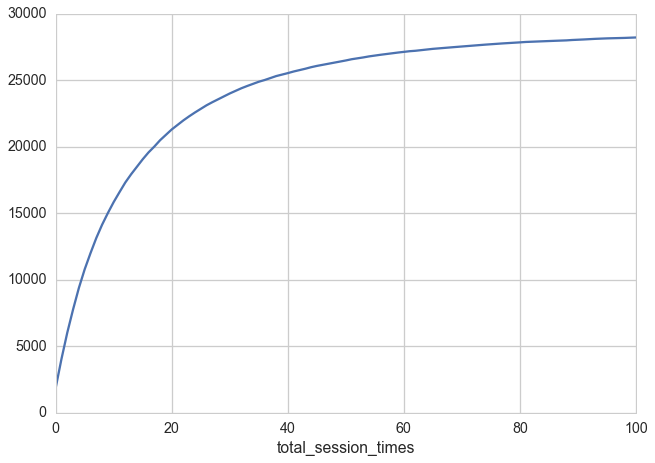

In [44]:
STTS[True].cumsum().plot()
plt.xlim([0,100])

(0, 100)

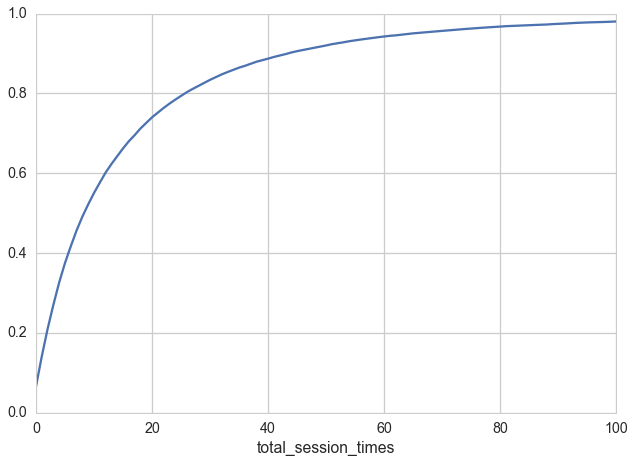

In [45]:
STTS['CumProp'].plot()
plt.xlim([0,100])

(0, 60)

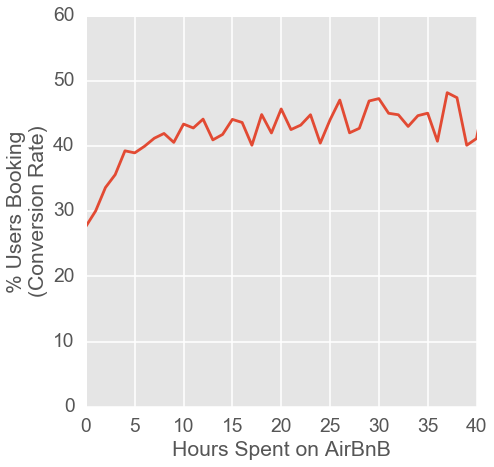

In [101]:
Figure = plt.figure(figsize=(7,7))
(STTS['Proportion']*100).plot()
plt.xlim([0,60])
plt.xlabel('Hours Spent on AirBnB')
plt.ylabel('% Users Booking\n(Conversion Rate)')
plt.xlim([0,40])
plt.ylim([0,60])

(0, 60)

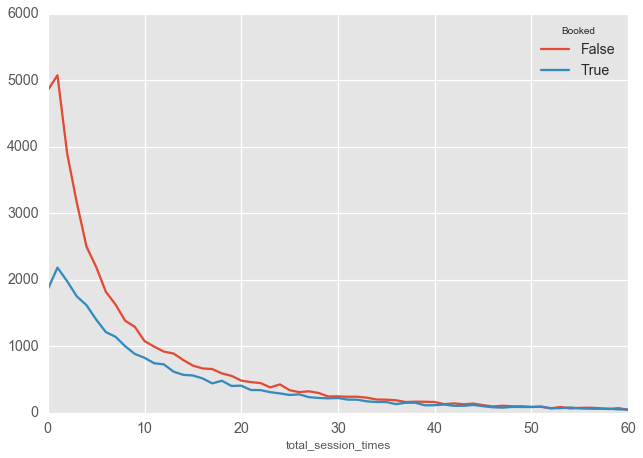

In [58]:
STTS[STTS.columns[0:2]].plot()
plt.xlim([0,60])

## For people we are predicting correctly, how much info do we have?

# What useful things could we do here?
### Identify who the at risk users who have been looking for a long time and otherwise have the profile of someone who would book? Identify pain points . . .

#### By that point we know where they're interested in booking. Might want to ask questions about is it a matter of price? Is it a matter of availability?

#### Find people who are dissatisfied with price in one region and find another . . .

In [48]:
ST['days_all'] = np.round(ST['all_time']/(3600*24))
STP = ST.groupby(['days_all','Booked']).count()['id'].unstack().fillna(0)
STP['Proportion'] = STP[True]/(STP[True]+STP[False])
STP['Total'] = (STP[True]+STP[False])
STP['CumProp'] = STP[True].cumsum()/STP[True].sum()

In [49]:
import matplotlib
matplotlib.style.use('ggplot')


In [50]:
STP['days_all'] = np.round(ST['all_time']/(3600*24))
STP = ST.groupby(['days_all','Booked']).count()['id'].unstack().fillna(0)
STP['Proportion'] = STP[True]/(STP[True]+STP[False])
STP['Total'] = (STP[True]+STP[False])
STP['CumProp'] = STP[True].cumsum()/STP[True].sum()

In [51]:
STP[True].sum()

28774.0

In [52]:
STP[True].cumsum().loc[100]

28285.0

(0, 100)

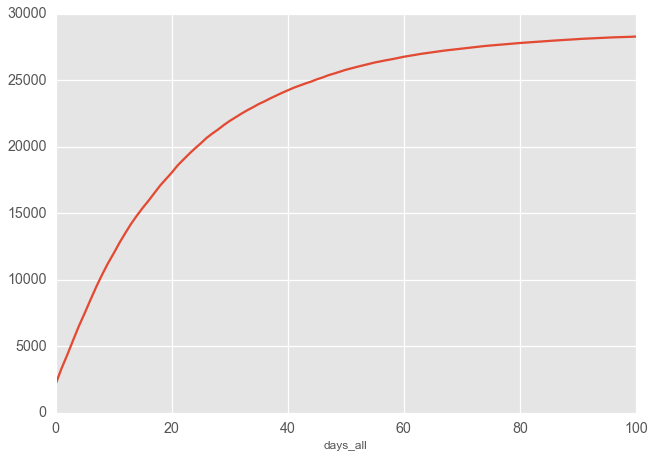

In [53]:
STP[True].cumsum().plot()
plt.xlim([0,100])

(0, 100)

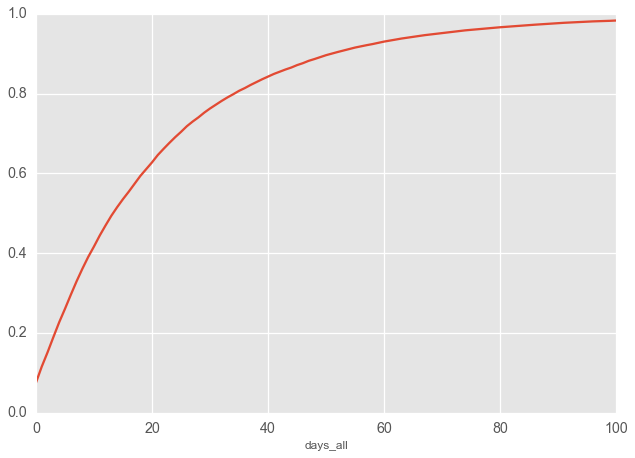

In [54]:
STP['CumProp'].plot()
plt.xlim([0,100])

(0, 40)

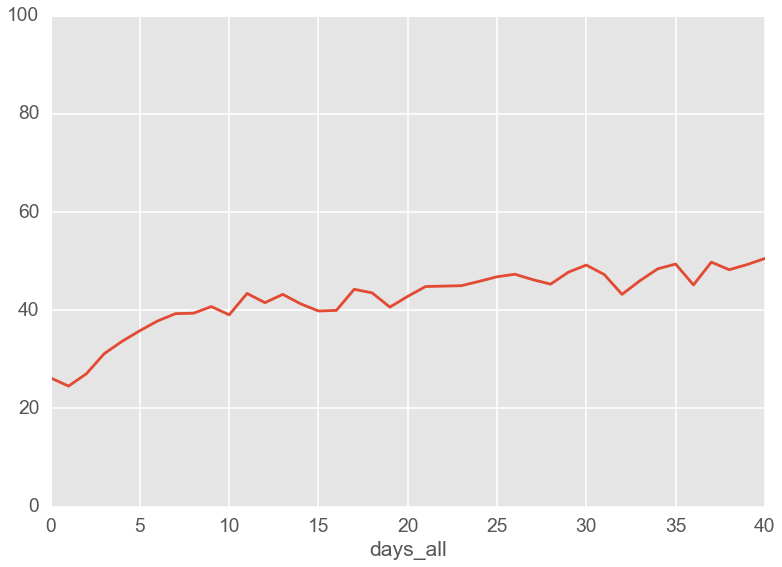

In [91]:
Figure = plt.figure(figsize=(7,7))
(STP['Proportion']*100).plot()
plt.xlim([0,40])
plt.xlabel

(0, 30)

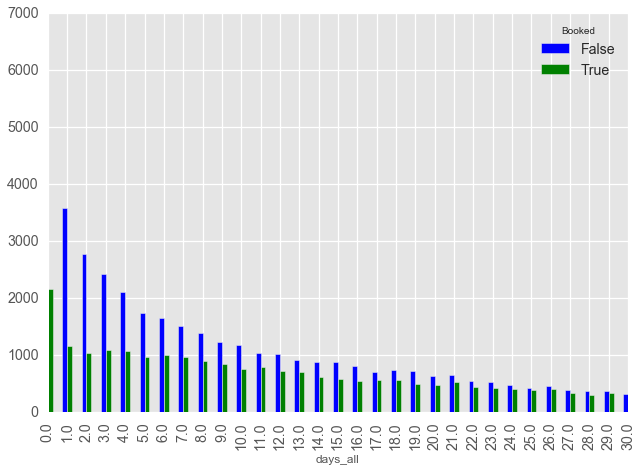

In [56]:
STP[STP.columns[0:2]].plot(kind='bar')
plt.xlim([0,30])

(0, 30)

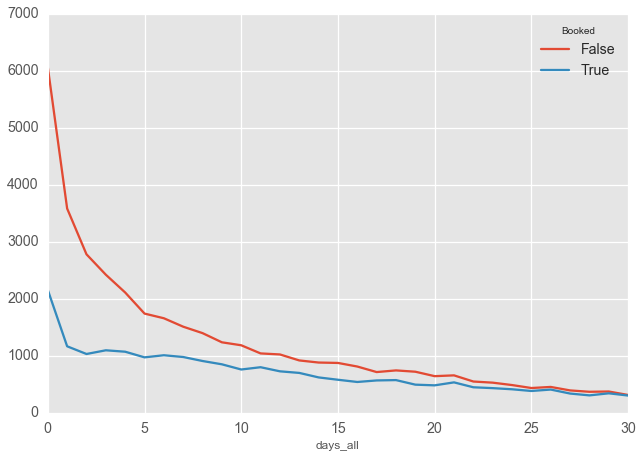

In [57]:
STP[STP.columns[0:2]].plot()
plt.xlim([0,30])

In [ ]:
## Can rerun this on hours of site usage.

In [ ]:
## Data Quality

In [ ]:
ST

In [73]:
ST.head()

,id,country_destination,total_session_times,num_actions_insession,mean_secs_per_action,mean_between_sessions,num_sessions,max_between_sessions,num_days,all_time,Booked,days_all
137021,d1mm9tcy42,other,16,86,673.081395,99832.363636,34,606881,21,3427529,True,40
137022,yo8nz8bqcq,NDF,3,5,2022.000000,49433.000000,5,115983,2,207842,False,2
137023,4grx6yxeby,NDF,2,7,1192.428571,125233.000000,10,336801,8,1135444,False,13
137024,ncf87guaf0,NDF,48,118,1458.932203,140378.400000,26,732296,16,3755100,False,43
137025,4rvqpxoh3h,GB,1,8,319.375000,0.000000,1,0,1,2555,True,0


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


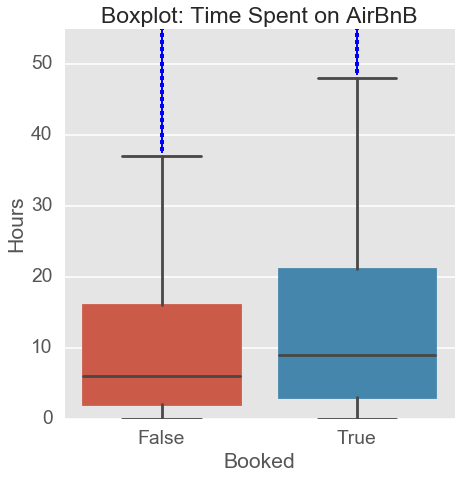

In [87]:
Figure = plt.figure(figsize=(7,7))
sns.set_context("poster", font_scale=1.2)
sns.boxplot(x="Booked",y="total_session_times",data=ST,order=[False,True])
plt.ylim([0,55])
plt.ylabel('Hours')
plt.title('Boxplot: Time Spent on AirBnB')

Bin according to number of days . . .
Then calculate proportion.

In [ ]:
ST

In [ ]:
ST.groupby(['id',])

In [ ]:
ST['num_days'].quantile(.98)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 23)

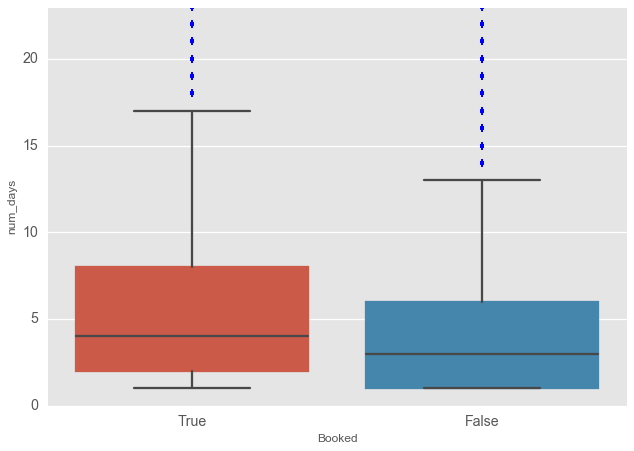

In [69]:
sns.boxplot(x="Booked",y="num_days",data=ST)
plt.ylim([0,23])

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


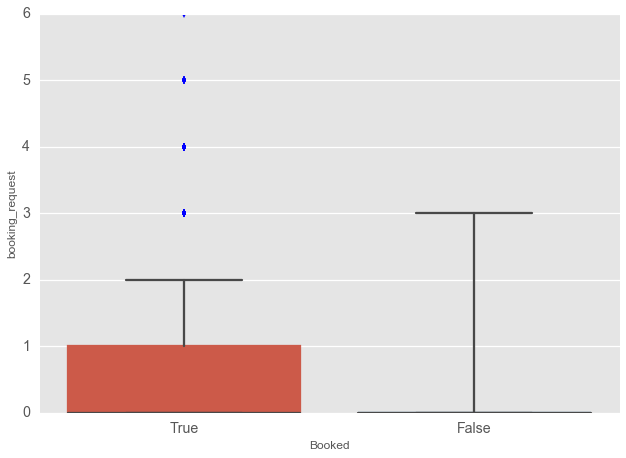

In [70]:
sns.boxplot(x="Booked",y="booking_request",data=Sessions)

In [ ]:

plt.boxplot(x=ST['num_days'],y='Booked')

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


TypeError: 'NoneType' object is not iterable

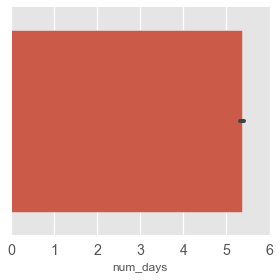

In [72]:
g = sns.factorplot(x='num_days',hue='Booked',data=ST,kind='bar')

In [ ]:
ST

In [ ]:
sessions_pure